## Estimation of covariance matrix

In [1]:
import sys
sys.path.append('../../Utilities')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [26]:
with open('gaussian_fit.stan', 'r') as file:
    print(file.read())

data {
  int<lower=1> N; // number of observations
  int<lower=1> J; // dimension of observations
  vector[J] y[N]; // observations
  vector[J] Zero; // a vector of Zeros (fixed means of observations)
}
parameters {
  cholesky_factor_corr[J] Lcorr;
  vector<lower=0>[J] sigma;
}
model {
  y ~ multi_normal_cholesky(Zero, diag_pre_multiply(sigma, Lcorr));
  sigma ~ exponential(1);
  Lcorr ~ lkj_corr_cholesky(10);
}
generated quantities {
  matrix[J,J] Omega;
  matrix[J,J] Sigma;
  Omega = multiply_lower_tri_self_transpose(Lcorr);
  Sigma = quad_form_diag(Omega, sigma);
}



In [4]:
model_lkj=stan_utility.compile_model('gaussian_fit.stan')

Using cached StanModel


In [5]:
np.random.seed(4052020)
Omega = np.matrix([[1, 0.3, 0.2],[.3, 1, 0.1],[0.2, 0.1, 1]])
sigma = np.array([1,2,3])
Sigma = np.diag(sigma)@Omega@np.diag(sigma)

In [27]:
N=100
y_sim=np.random.default_rng().multivariate_normal([0,0,0],Sigma,size=N)

In [28]:
data=dict(N=N,J=y_sim.shape[1],y=y_sim,Zero=np.zeros(y_sim.shape[1]))

In [29]:
fit=model_lkj.sampling(data=data,seed=4052020)

In [30]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat for parameter Lcorr[1,1] is nan!
Rhat for parameter Lcorr[1,2] is nan!
Rhat for parameter Lcorr[1,3] is nan!
Rhat for parameter Lcorr[2,3] is nan!
Rhat for parameter Omega[1,1] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [31]:
params=fit.extract()
omega12=np.array([params['Omega'][k][0,1] for k in range(4000)])
omega13=np.array([params['Omega'][k][0,2] for k in range(4000)])
omega23=np.array([params['Omega'][k][1,2] for k in range(4000)])

In [32]:
y_sim=np.concatenate((params['sigma'],omega12[:,None],omega13[:,None],omega23[:,None]),axis=1)
names_lt=['$\sigma_1$','$\sigma_2$','$\sigma_3$','$\omega_{12}$','$\omega_{13}$','$\omega_{23}$']
tv=[1,2,3,0.3,0.2,0.1]

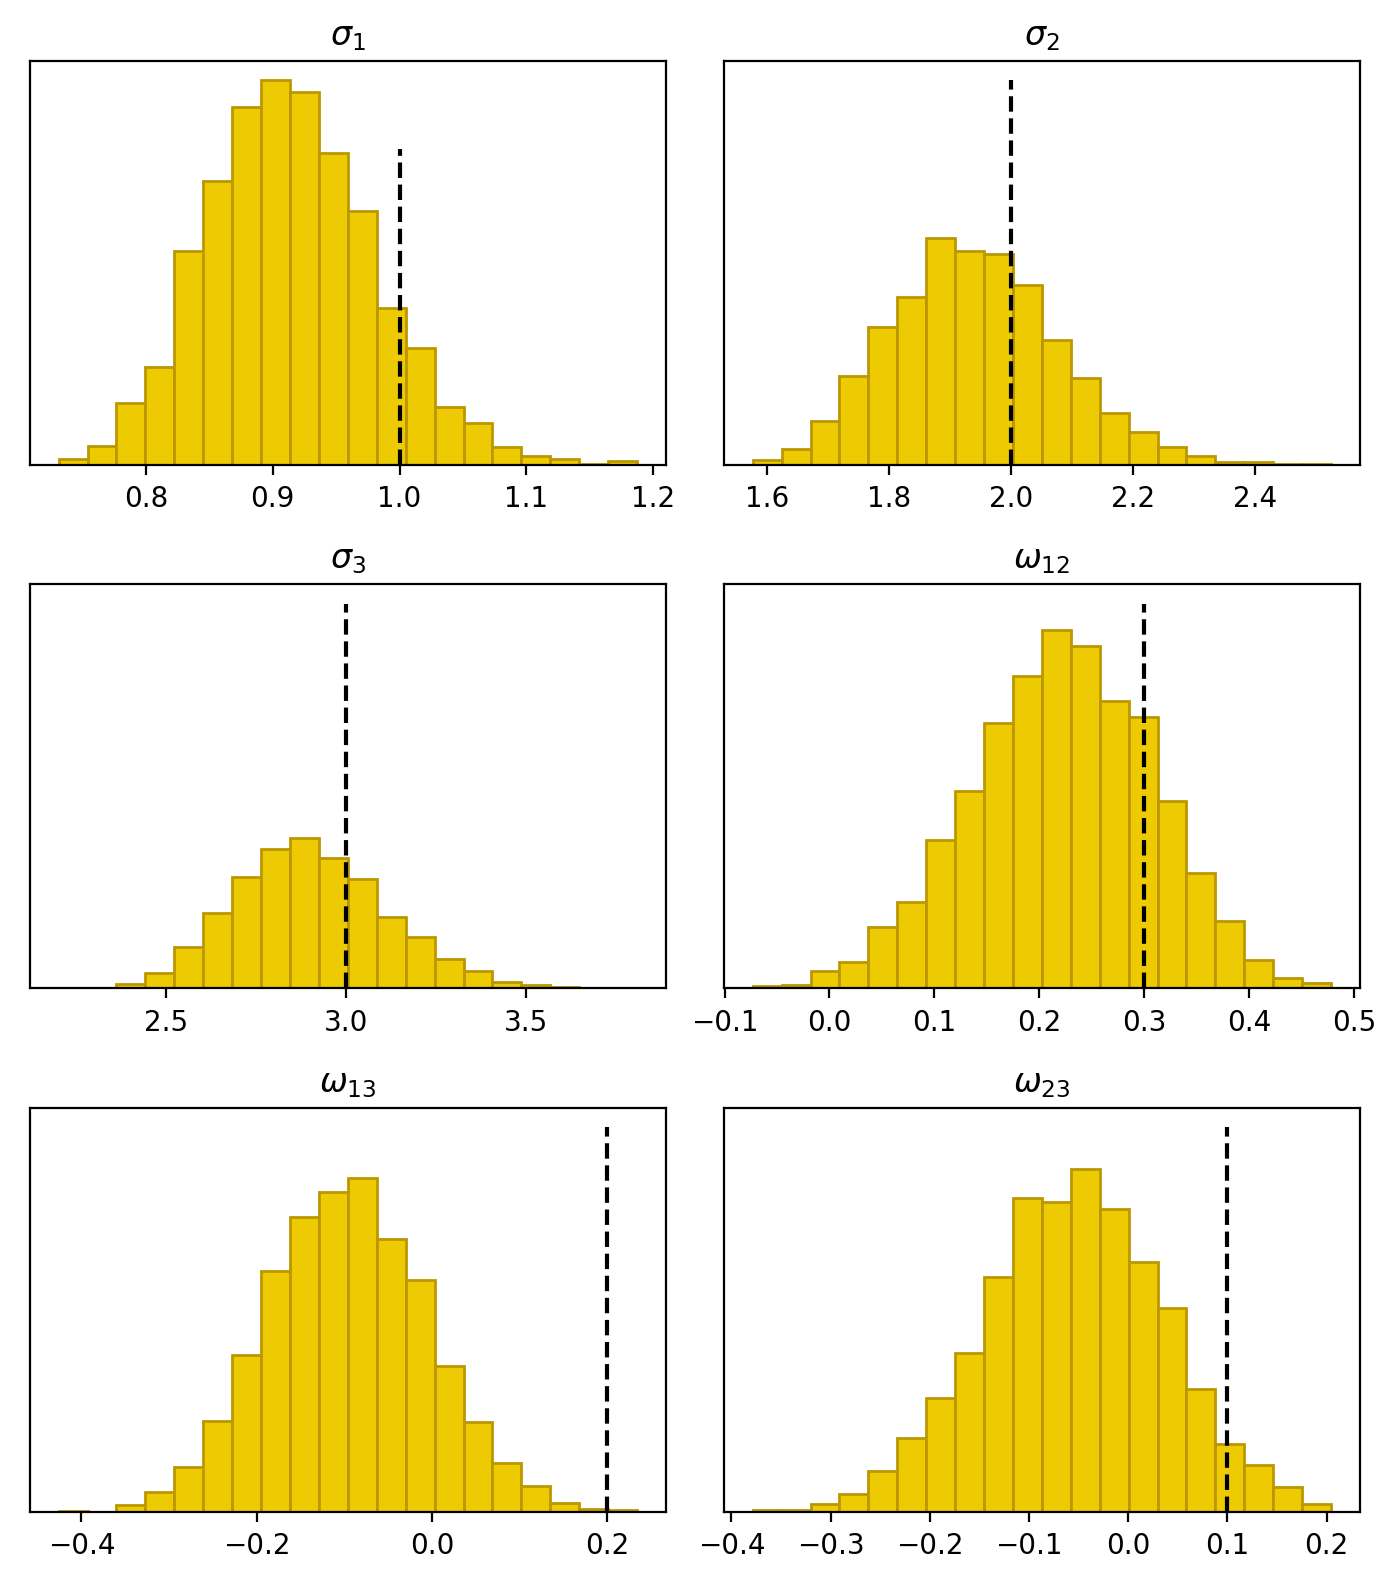

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
for k in range(6):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(names_lt[k])
    ax.plot([tv[k],tv[k]],[0,5],linestyle='--',color='black')
    #ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [34]:
names=['sigma_1','sigma_2','sigma_3','omega_12','omega_13','omega_23']
nm_it=iter(names)
for col in zip(*y_sim):
    print(next(nm_it))
    print('Median: {:4.2f}'.format(np.median(col)))
    print('90% confidence interval: ',['{:4.2f}'.format(k) for k in np.percentile(col,[5,95],axis=0)])

sigma_1
Median: 0.91
90% confidence interval:  ['0.81', '1.03']
sigma_2
Median: 1.94
90% confidence interval:  ['1.73', '2.18']
sigma_3
Median: 2.89
90% confidence interval:  ['2.58', '3.26']
omega_12
Median: 0.22
90% confidence interval:  ['0.08', '0.36']
omega_13
Median: -0.10
90% confidence interval:  ['-0.24', '0.05']
omega_23
Median: -0.05
90% confidence interval:  ['-0.21', '0.09']


In [35]:
Sigma_sim=params['Sigma']
SIGMA=Sigma_sim[0]*0
for k in Sigma_sim:
    SIGMA += S
SIGMA/4000

array([[0.99305491, 0.60261163, 0.58105376],
       [0.60261163, 3.995262  , 0.67141518],
       [0.58105376, 0.67141518, 9.35785433]])

In [16]:
Sigma

matrix([[1. , 0.6, 0.6],
        [0.6, 4. , 0.6],
        [0.6, 0.6, 9. ]])